# Along isopycnal spice gradients

Here we consider the properties of spice gradients along isopycnals. We do this using the 2 point differences and their distributions. 

This is similar (generalization) to the spice gradients that Klymak et al 2015 considered. 

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [2]:
ds_660_rho = xr.open_dataset('data/ctd_660_isopycnal_grid_14_july_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (alpha*dCT + beta*dSA).rename('Spice')

In [3]:
ds_660_rho

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...
    Spice         (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

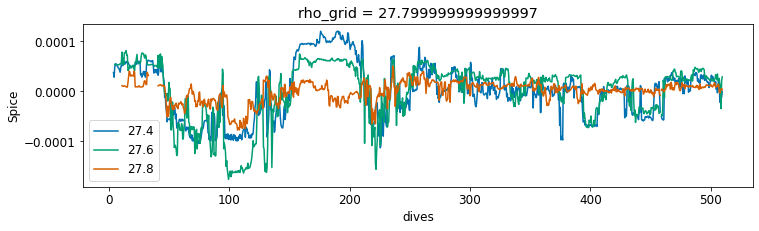

In [4]:
plt.figure(figsize=(12,3))
ds_660_rho.Spice.sel(rho_grid=27.4, method='nearest').plot(label='27.4')
ds_660_rho.Spice.sel(rho_grid=27.6, method='nearest').plot(label='27.6')
ds_660_rho.Spice.sel(rho_grid=27.8, method='nearest').plot(label='27.8')
plt.legend()

#### Analysis at single depth

In [5]:
# Select the data we want to use for looking at properties

ds_sel = ds_660_rho.sel(rho_grid=27.8, method='nearest')

lon_sel = ds_sel.longitude.values.reshape((-1,1))
lat_sel = ds_sel.latitude.values.reshape((-1,1))
time_sel = ds_sel.days.values.reshape((-1,1))

Spice_sel = ds_sel.Spice.values.reshape((-1,1))

Xvec = np.concatenate([lon_sel, lat_sel], axis=1) # mXn, where m is number of obs and n is dimension


In [6]:
#def great_circle_distance(lon1, lat1, lon2, lat2):
def great_circle_distance(X1, X2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    
    # Change form of input to make compliant with pdist
    lon1 = X1[0]
    lat1 = X1[1]
    lon2 = X2[0]
    lat2 = X2[1]
    
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [7]:
from scipy.spatial.distance import pdist
# Compute the corresponding differences. 
# We will be able to condition on dX and dTime to compute
# the differences needed for looking at gradients. 
dX = pdist(Xvec, great_circle_distance)*110e3 # convert to m
dTime = pdist(time_sel, 'cityblock')

#dCT = pdist(CT_sel, lambda u, v: (u-v)) 
# We use these signed differences because we care about compensations.
#dSA = pdist(SA_sel, lambda u, v: (u-v))
dSpice = pdist(Spice_sel, 'cityblock') # we just want to know the abs diff

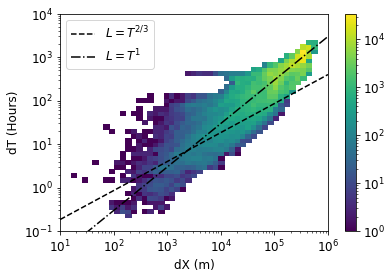

In [8]:
import matplotlib.colors as colors

plt.hist2d(dX, dTime*24, bins=(np.logspace(1,6), np.logspace(-1,4)),
          norm=colors.LogNorm());
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dX (m)')
plt.ylabel('dT (Hours)')

L = np.logspace(1,6)
T23 = 4e-2*L**(2/3)
T1 = 3e-3*L
#y32 = 1e-5*x**(3/2)
plt.plot(L,T23, label='$L=T^{2/3}$', color='k', linestyle='--')
plt.plot(L,T1, label='$L=T^{1}$', color='k', linestyle='-.')

plt.legend()

Text(0.5, 1.0, 'Histogram of empirically chosen points')

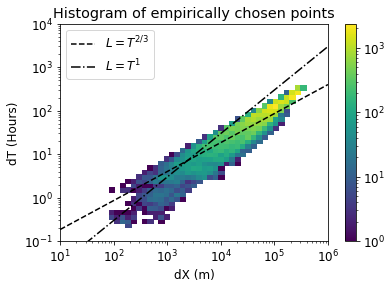

In [9]:
cond = (dTime <= 3e-3*dX**(2/3)) 
plt.hist2d(dX[cond], dTime[cond]*24, bins=(np.logspace(1,6), np.logspace(-1,4)),
          norm=colors.LogNorm());
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dX (m)')
plt.ylabel('dT (Hours)')

L = np.logspace(1,6)
T23 = 4e-2*L**(2/3)
T1 = 3e-3*L
#y32 = 1e-5*x**(3/2)
plt.plot(L,T23, label='$L=T^{2/3}$', color='k', linestyle='--')
plt.plot(L,T1, label='$L=T^{1}$', color='k', linestyle='-.')

plt.legend()

plt.title('Histogram of empirically chosen points')


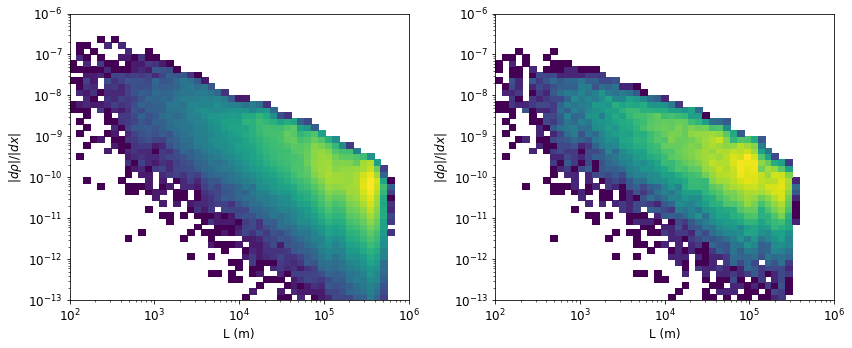

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist2d(dX, dSpice/dX, bins=(np.logspace(2,6), np.logspace(-13, -6)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| / |dx| $')

plt.subplot(122)
plt.hist2d(dX[cond], (dSpice/dX)[cond], bins=(np.logspace(2,6), np.logspace(-13, -6)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| / |dx| $')
plt.tight_layout()

In [11]:
Hspice, xedges, yedges = np.histogram2d(dX[cond], (dSpice/dX)[cond],
                                      bins=(np.logspace(2,6,31), np.logspace(-13, -6, 37)))
xmid = 0.5*(xedges[0:-1] + xedges[1:])
ymid = 0.5*(yedges[0:-1] + yedges[1:])

Hspice_Xdnorm = Hspice/ Hspice.sum(axis=1).reshape((-1,1))

Text(0.5, 1.0, 'PDF of spice gradient normalized at each scale')

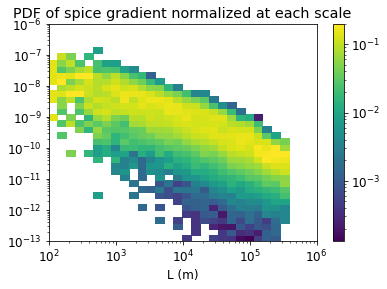

In [12]:
plt.pcolor(xedges, yedges, Hspice_Xdnorm.T, norm=colors.LogNorm(vmax=.2))
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')

plt.title('PDF of spice gradient normalized at each scale')

Text(0, 0.5, 'PDF')

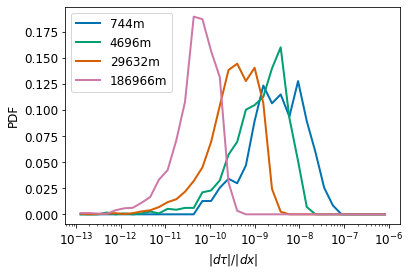

In [13]:
for i in range(6,len(xmid),6): 
    plt.plot(ymid, Hspice_Xdnorm[i,:], label=str(int(xmid[i]/1)) + 'm', linewidth=2)
plt.xscale('log')
#plt.xlim([5e-9, 1e-3])
plt.legend()
plt.xlabel(r'$ |d \tau| / |dx| $')
plt.ylabel('PDF')

Unlike the surface buoyancy gradients, there is less of a suggestion of saturation at the small scales. Suggesting that even if the is a natural limit to the smallest gradients (wave mixing or such), it is not reached at a few 100m. 

This result seems to be similar, regardless of the isopycnal we are considering (tried this by changing the density level manually). 

Things to try: 
- Second order structure functions (do they look more like k^-1 or k^-2?) 
- 4th order structure functions could also help as a summary metric

### Structure functions 

Here we consider the structure functions; quantities like $<d\tau ^n>$.

Power law scalings go as, at $k^{-\alpha}$ in power spectrum will appear at $r^{\alpha-1}$ in spectra.  
So a power law scaling of 2/3 corresponds to $-5/3$, while shallower than 2/3 would correspond to shallower. 

In [51]:
bins=np.logspace(2,6,14)

S2 = np.zeros_like(bins)
S4 = np.zeros_like(bins)

dX_cond = dX[cond]
dSpice_cond = dSpice[cond]

for i in range(0, len(bins)-1): 
    
    S2[i] = np.mean(dSpice_cond[ (dX_cond> bins[i]) & (dX_cond <= bins[i+1])]**2)
    S4[i] = np.mean(dSpice_cond[ (dX_cond> bins[i]) & (dX_cond <= bins[i+1])]**4)

Text(0, 0.5, '$< d \\tau ^2>$')

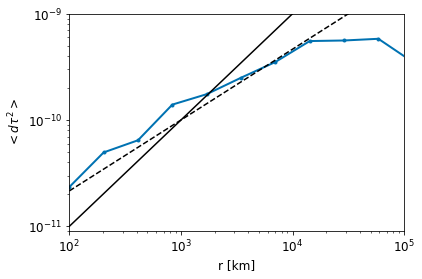

In [52]:
plt.plot(bins, S2, '.-', linewidth=2)
plt.plot(bins, 1e-13*bins**1, '-', color='k')
plt.plot(bins, 1e-12*bins**(2/3) , '--', color='k')
plt.xscale('log')
plt.yscale('log')

plt.ylim([9e-12, 1e-9])
plt.xlim([1e2, 1e5])

plt.xlabel('r [km]')
plt.ylabel(r'$< d \tau ^2>$')

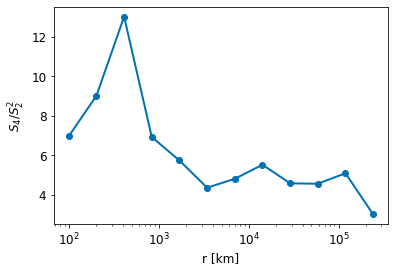

In [53]:
plt.plot(bins, S4/(S2**2), 'o-', linewidth=2)

plt.xlabel('r [km]')
plt.ylabel(r'$S_4/S_2^2$')

plt.xscale('log')

The second order structure of spice follow as power law of about 2/3, which corresponds to about -5/3 slope of tracers. This is slightly at odds with the $k^{-2}$. scaling seen in wavenumber. However, note that this is still very far from $r^0$ (constant) that one might expect is the $k^{-1}$ case (which is what theory would predict). 